# Evaluate a privacy policy

Today, virtually every organization with which you interact will collect or use some about you. Most typically, the collection and use of these data will be disclosed according to an organization's privacy policy. We encounter these privacy polices all the time, when we create an account on a website, open a new credit card, or even sign up for grocery store loyalty program. Yet despite (or perhaps because of) their ubiquity, most people have never read a privacy policy from start to finish. Moreover, even if we took the time to read privacy policies, many of us would struggle to fully understand them due to their frequent use of complex, legalistic, and opaque language. These considerations raise many potential ethical questions regarding whether organizations are sufficiently transparent about the increasingly vast sums of data they collect about their users, customers, employees, and other stakeholders.

The purpose of this notebook is to help you gain a better understanding of the landscape of contemporary privacy policies, using a data-driven approach. We'll leverage a [new dataset](https://github.com/ansgarw/privacy) that provides the full text of privacy policies for hundreds of publicly-traded companies, which we'll analyze using some techniques from natural language processing. By the time you make your way through this notebook, you should have a better understanding of the diverse form and content of modern privacy policies, their linguistic characteristics, and a few neat tricks for analyzing large textual data with Python. Without further ado, let's get started!

# Roadmap
  * Preliminaries (packages + data wrangling)
  * Topic models
  * Keywords in context
  * Named entities
  * Readability
  * Embeddings
  * Exercises

# Preliminaries

Let's start out by loading some packages. We'll be using pandas to help with data wrangling and holding the data in an easy to work with data frame format. The json package is part of the Python Standard Library and will help us with reading the raw data. Matplotlib is for plotting; umap is for clustering policies and is not completely necessary. Finally, we'll use several natural language processing packages, spacy, textacy, and gensim, for the actual text analysis. 

In [1]:
# run the following commands to install the needed packages
"""
pip install pandas
pip install spacy
python -m spacy download en_core_web_lg
pip install textacy
pip install gensim
pip install umap
pip install matplotlib
"""

'\npip install pandas\npip install spacy\npython -m spacy download en_core_web_lg\npip install textacy\npip install gensim\npip install umap\npip install matplotlib\n'

In [2]:
# load some packages
import pandas as pd
import json
import spacy
import textacy
import textacy.text_stats
import gensim
import matplotlib.pyplot as plt
import umap
import umap.plot
from umap import umap_
from bokeh.plotting import show, output_notebook
import tqdm
tqdm.tqdm.pandas()

# for umap warnings
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel("ERROR")

# load spacy nlp model
nlp = spacy.load("en_core_web_lg", disable=["parser"])
nlp.max_length = 2000000

Now, let's go ahead and load the data. 

In [3]:
# load the data
with open("data/policies.json") as f:
  policies_df = pd.DataFrame({k:" ".join(v) for k,v in json.load(f).items()}.items(), 
                             columns=["url","policy_text"])

In [4]:
# check out the results
policies_df.head()

,url,policy_text
0,www.dsny.com,Investors Investors Home Stock Quote and Chart...
1,www.brf-global.com,BRF’s investor relations website includes forw...
2,www.belmond.com,"Between fig trees and vibrant floodplains, be ..."
3,www.pieris.com,Use of cookies on this website: This website u...
4,www.isoray.com,We respect your privacy and take Internet priv...


Looks pretty reasonable. We have one column for the URL and one for the full text of the privacy policy. Note that the orignal data come in a json format, and there, each URL is associated with a set of paragraphs that constitute each privacy policy. In the code above, when we load the data, we concatenate these paragraphs to a single text string, which will be easier for us to work with in what follows. 

Our next step will be to process the documents with spacy. We'll add a column to our data frame with the processed documents (that way we still have the raw text handy). This might take a minute. If it takes too long on your machine, you can just look at a random sample of policies. Just uncomment out the code below.

In [5]:
policies_df = policies_df.sample(frac=0.05) # set frac to some fraction that will run in a reasonable time on your machine

In [6]:
policies_df["policy_text_processed"] = policies_df.policy_text.progress_apply(nlp)

100%|██████████| 203/203 [02:21<00:00,  1.44it/s]


With that simple line of code, spacy has done a bunch of hard work for us, including things like tokenization, part-of-speech tagging, entity parsing, and other stuff that go well beyond our needs today. Let's take a quick look.

In [7]:
policies_df.head()

,url,policy_text,policy_text_processed
1886,investors.boxlight.com,"By using or accessing this website, you signif...","(By, using, or, accessing, this, website, ,, y..."
1602,www.westernunion.com,You are currently browsing in private mode. To...,"(You, are, currently, browsing, in, private, m..."
850,www.scana.com,SCANA Corporation (“SCANA Corporation and its ...,"(SCANA, Corporation, (, “, SCANA, Corporation,..."
3581,www.unfi.com,"At UNFI, your right to privacy and data securi...","(At, UNFI, ,, your, right, to, privacy, and, d..."
1783,www.spathinc.com,Straight Path Communications Inc. (“Straight P...,"(Straight, Path, Communications, Inc., (, “, S..."


Okay, at this point, we've loaded all the packages we need, and we've done some of the basic wrangling necessary to get the data into shape. We'll need to do a little more data wrangling to prepare for a few of the analyses in store below, but we've already done enough to let us get started. So without further ado, let's take our first peek at the data. 

# Topic models

We'll start out by trying to get a better sense for __what__ is discussed in corporate privacy policies. To do so, we'll make use of an approach in natural language processing known as topic models. Given our focus, we're not going to go into any of the methodological details of how these models work, but in essence, what they're going to do is search for a set of latent topics in our corpus of documents (here, privacy policies). You can think of topics as clusters of related words on a particular subject (e.g., if we saw the words "homework", "teacher", "student", "lesson" we might infer that the topic was school); documents can contain discussions of multiple topics.

To start out, we'll do some more processing on the privacy policies to make them more useable for our topic modeling library (called gensim).

In [8]:
# define a processing function
process_gensim = lambda tokens: [token.lemma_.lower() for token in tokens if not(token.is_punct or token.is_stop or token.is_space or token.is_digit)]

# apply the function
policies_df["policy_text_gensim"] = policies_df.policy_text_processed.apply(process_gensim)

In [9]:
# create a gensim dictionary
gensim_dict = gensim.corpora.dictionary.Dictionary(policies_df["policy_text_gensim"])

In [10]:
# create a gensim corpus
gensim_corpus = [gensim_dict.doc2bow(policy_text) for policy_text in policies_df["policy_text_gensim"]]

In [11]:
# fit the topic model
lda_model = gensim.models.LdaModel(gensim_corpus,
                                   id2word=gensim_dict,
                                   num_topics=10)

In [12]:
# show the results
lda_model.show_topics(num_topics=-1, num_words=8)

[(0,
  '0.052*"information" + 0.019*"personal" + 0.019*"use" + 0.016*"site" + 0.014*"provide" + 0.013*"website" + 0.011*"privacy" + 0.011*"service"'),
 (1,
  '0.042*"information" + 0.016*"personal" + 0.015*"service" + 0.014*"use" + 0.013*"website" + 0.012*"provide" + 0.009*"site" + 0.008*"privacy"'),
 (2,
  '0.033*"information" + 0.014*"use" + 0.014*"personal" + 0.012*"service" + 0.010*"w" + 0.010*"website" + 0.010*"t" + 0.009*"provide"'),
 (3,
  '0.036*"information" + 0.019*"use" + 0.012*"site" + 0.012*"party" + 0.009*"privacy" + 0.009*"datum" + 0.009*"service" + 0.009*"provide"'),
 (4,
  '0.016*"information" + 0.009*"provide" + 0.008*"service" + 0.008*"w" + 0.008*"t" + 0.008*"website" + 0.008*"use" + 0.007*"personal"'),
 (5,
  '0.026*"information" + 0.022*"personal" + 0.019*"use" + 0.016*"site" + 0.012*"website" + 0.011*"privacy" + 0.011*"service" + 0.010*"policy"'),
 (6,
  '0.030*"information" + 0.013*"provide" + 0.011*"personal" + 0.010*"website" + 0.010*"use" + 0.010*"party" + 0.0

As a bonus, we can also check the coherence, essentially a model fit (generally, these measures look at similarity among high scoring words in topics). If you're so inclined, you can re-run the topic model above with different hyperparameters to see if you can get a better fit; I didn't spend a whole lot of time tuning. 

In [13]:
# get coherence
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=policies_df["policy_text_gensim"], dictionary=gensim_dict, coherence="c_v")
coherence_model_lda.get_coherence()

0.39987803675107597

Take a look at the topics identified by the models above. Can you assign human-interpretable labels to them? What can you learn about the different topics of discussion in privacy policies?

# Key words in context

Topic models are nice, but they're a bit abstract. They give us an overview about interesting clusters of words, but they don't tell us much about how particular words or used or the details of the topics. For that, we can actually learn a lot just by picking out particular words of interest and pulling out their context from the document, known as a "keyword in context" approach. 

As an illustration, the code below pulls out uses of the word "third party" in the policies of 20 random firms. There's no random seed set, so if you run the code again you'll get a different set of result. In the comment on the first line, I've given you a few additional words you may want to check.

In [14]:
KEYWORD = "right" # "third party" # privacy, right, duty, selling, disclose, trust, inform
NUM_FIRMS = 20
with pd.option_context("display.max_colwidth", 100, "display.min_rows", NUM_FIRMS, "display.max_rows", NUM_FIRMS):
  display(
           pd.DataFrame(policies_df.sample(n=NUM_FIRMS).apply(lambda row: list(textacy.extract.kwic.keyword_in_context(row["policy_text"], 
                                                                               keyword=KEYWORD, 
                                                                               window_width=35)), axis=1).explode()).head(NUM_FIRMS)
)

,0
1710,"(rest to you. You can exercise your , right, to prevent such contact by setting)"
1710,"(ecessary to protect and defend the , right, s or property of Illumina, Inc., it)"
1710,"(to comply with law, to enforce any , right, s in connection with the Site, our )"
1710,"(rsist indefinitely. We reserve the , right, to change this Privacy Policy at a)"
4028,"(o that you are aware of your legal , right, s and obligations with respect to C)"
4028,"(third party. Intellectual Property , Right, s. We own the copyright in this Sit)"
4028,"(al Property Rights. We own the copy, right, in this Site and its content, incl)"
4028,"( of this Site are protected by copy, right, and/or other intellectual property)"
4028,"(and/or other intellectual property , right, s, and Compugen owns and retains al)"
4028,"(mpugen owns and retains all of its , right, s in the content and the Site. No c)"


Run the code for some different words, not just the ones in my list, but also those that interest you. Can you learn anything about corporate mindsets on privacy? What kind of rights are discussed?

# Named entities

Another way we can gain some insight into the content of privacy policies is by seeing who exactly they discuss. Once again, spacy gives us an easy (if sometimes rough) way to do this. Specifically, when we process a document using spacy, it will automatically extract several different categories of named entities (e.g., person, organization, place, you can find the full list [here](https://spacy.io/api/annotation)). In the code, we'll pull out all the organization and person entities. 

In [15]:
# extract named entities from the privacy policies
pull_entities = lambda policy_text: list(set([entity.text.lower() for entity in policy_text.ents if entity.label_ in ("ORG", "PERSON")]))
policies_df["named_entities"] = policies_df.policy_text_processed.apply(pull_entities)

Let's take a quick peek at our data frame and see what the results look like.

In [16]:
# look at the entities
with pd.option_context("display.max_colwidth", 100, "display.min_rows", 50, "display.max_rows", 50):
  display(policies_df[["url","named_entities"]].head(50))

,url,named_entities
1886,investors.boxlight.com,"[the eu data privacy directive, boxlight]"
1602,www.westernunion.com,"[joint marketing, western union, western union financial services, inc., vigo, social security, ..."
850,www.scana.com,"[scana services, inc., the georgia public service commission, facebook, the north carolina utili..."
3581,www.unfi.com,"[the company’s information protection, eu, customer service, the safe harbor privacy principles,..."
1783,www.spathinc.com,"[ip, straight path communications inc.]"
3186,www.deepwater.com,"[securities and exchange commission, transocean, isp]"
3809,www.neenah.com,"[general data protection regulation, neenah, inc., eu, eea visitors, european commission, standa..."
4027,www.digitalrealty.com,"[the personal data, health & safety management, processor, relevant personal data, cookies, cont..."
2888,www.agnc.com,"[agnc investment corp., american capital agency corp.]"
53,www.promisneurosciences.com,[data]


Now let's add a bit more structure. We'll run a little code to help us identify the most frequently discussed organizations and people in the corporate privacy policies. 

In [17]:
# pull the most frequent entities
entities = policies_df["named_entities"].explode("named_entities")
NUM_WANTED = 50
with pd.option_context("display.min_rows", 50, "display.max_rows", 50):
  display(entities.groupby(entities).size().sort_values(ascending=False).head(50))

named_entities
ip                                              65
site                                            47
eu                                              35
the european union                              29
google analytics                                27
the european economic area                      22
eea                                             22
google                                          20
facebook                                        19
twitter                                         18
company                                         16
cookies                                         13
website                                         13
flash                                           12
european union                                  11
the european commission                         11
personal data                                   11
the digital advertising alliance                10
the u.s. department of commerce                  9
the network adve

What do you make of the most frequent entities? Are you surprised? Do they fit with what you expected? Can we make any inferences about the kind of data sharing companies might be enaging in by looking at these entities?

# Readability

Next, we'll evaluate the privacy policies according to their readability. There are many different measures of readability, but the basic idea is to evaluate a text according to various metrics (e.g., words per sentence, number of syllables per word) that correlate with, well, how easy it is to read. The textacy package makes it easy to quickly evaluate a bunch of different metrics of readability. Let's compute them and then do some exploration. For now, I'll pull out the Flesch-Kincaid grade level and the Gunning-Fog index (both are grade-level measures). 

In [18]:
# compute flesch_kincaid_grade_level
policies_df["flesch_kincaid_grade_level"] = policies_df.policy_text_processed.apply(textacy.text_stats.readability.flesch_kincaid_grade_level)

In [19]:
# compute gunning_fog_index
policies_df["gunning_fog_index"] = policies_df.policy_text_processed.apply(textacy.text_stats.readability.gunning_fog_index)

You can now access the various statistics for individual documents as follows (e.g., for the document at index 0).

In [20]:
policies_df.iloc[0]["flesch_kincaid_grade_level"]

11.936183169375536

This tells us the Flesch-Kinkaid grade level for the policy. We're probably not terribly interested in the readability of any given policy. We can do a little wrangling with pandas to extract various metrics for all policies and add them to the data frame. 

In [21]:
# let's clean up some extreme values
policies_df.loc[(policies_df.flesch_kincaid_grade_level < 0) | (policies_df.flesch_kincaid_grade_level > 20), "flesch_kincaid_grade_level"] = None
policies_df.loc[(policies_df.gunning_fog_index < 0) | (policies_df.gunning_fog_index > 20), "gunning_fog_index"] = None

I would encourage you to adapt the code above to pull out some other readability-related features that seem interesting. You can find the full list available in our `TextStats` object [here](https://textacy.readthedocs.io/en/stable/api_reference/text_stats.html), in the textacy documentation. Let's plot the values we just extracted.

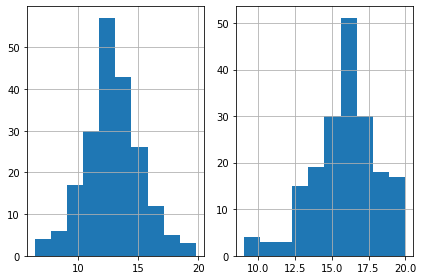

In [22]:
# plot with matplotlib
fig, axes = plt.subplots(1, 2)
policies_df["flesch_kincaid_grade_level"].hist(ax=axes[0])
policies_df["gunning_fog_index"].hist(ax=axes[1])
plt.tight_layout()

These results are pretty striking, especially when you consider them alongside statistics on the literacy rate in the United States. According to [surveys](https://www.oecd.org/skills/piaac/Country%20note%20-%20United%20States.pdf) by the OECD, about half of adults in the United States can read at an 8th grade level or lower. 

# Embeddings
Yet another way that we can gain some intuition on privacy policies is by seeing how similar or different particular policies are from one another. For example, we might not be all that surprised if we saw that Google's privacy policy was quite similar to Facebook's. We might raise an eyebrow if we saw that Nike and Facebook also had very similar privacy policies. What kind of data are they collecting on us when we buy our sneakers? One way we can compare the similarity among documents (here, privacy policies) is by embedding them in some high dimensional vector space, and the using linear algebra to find the distance between vectors. Classically, we would do this by representing documents as vectors of words, where entries represent word frequencies, and perhaps weighting those frequencies (e.g., using TF-IDF). Here, we'll use a slightly more sophisticated approach. When we process the privacy policies using spacy, we get a vector representation of each document, which is based on the word embeddings for its constituent terms. Again, given the focus of this class, we're not going to go into the methodological details of word embeddings, but you can think of them as a vectorization that aims to capture semantic relationships.

Below, we'll pull the document embeddings from spacy. We'll then do some dimension reduction using a cool algorithm from topological data analysis known as [Uniform Manifold Approximation and Projection](https://arxiv.org/abs/1802.03426) (UMAP), and visualize the results using an interactive plot. 

In [23]:
# pull the document embeddings from spacy and format for clustering
embeddings_df = policies_df[["url", "policy_text_processed"]]
embeddings_df = embeddings_df.set_index("url")
embeddings_df["policy_text_processed"] = embeddings_df["policy_text_processed"].apply(lambda text: text.vector)
embeddings_df = embeddings_df.policy_text_processed.apply(pd.Series)

<AxesSubplot:>

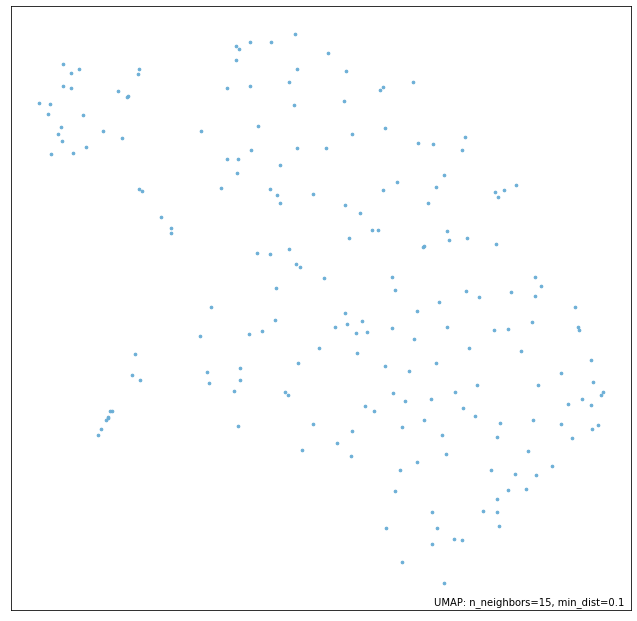

In [24]:
# non-interactive plot
# mapper = umap.UMAP().fit(embeddings_df.to_numpy())
mapper = umap.umap_.UMAP().fit(embeddings_df.to_numpy())
umap.plot.points(mapper)

In [25]:
# interactive plot
output_notebook()
hover_df = embeddings_df.reset_index()
hover_df["index"] = hover_df.index
p = umap.plot.interactive(mapper, labels=hover_df["index"], hover_data=hover_df[["index","url"]], point_size=2)
umap.plot.show(p)

Loading BokehJS ...

Explore the plots a bit. Can you observe any patterns in the results? Did you expect more or less variation? What do you make of the different clusters?

# Exercises
  * Going back to the keyword-in-context exercise, consider several additional keywords that may give you insight into how different companies are thinking about privacy. How often, for instance, do you see the word "rights" used? How often in conjunction with the word privacy? Do you find evidence of considerations for fairness? 
  * We've seen that the reading level for most privacy policies is quite high, but it's often a little difficult to interpret what, for example, a document written at a grade 14 reading level looks like. To gain some intuition, compute readability scores for some of your own writing (e.g., a prior course paper) and/or for some page on Wikipedia (you can use python, or do a quick Google search for an online readability calculator). How does the writing level of those compare to the privacy policies? 
  * There is a general presumption that many companies use fairly standardized (or boilerplate) privacy policies that are aimed primarily at avoiding legal liability, and that do not describe their particular data practices in detail. Do we see support for these views in the data? Do the privacy policies seem more or less variable than you expected? What are the implications for customers and other stakeholders?
  * Spend some time exploring the data using any of the techniques above, or your own favorite analytical approach or tools. What additional insights can we learn about privacy policies?